# Projekat Genomska Informatika

## Teodora Radaljac 3098/2023

Spatially variable genes (SVG) in spatial transcriptomics datasets are defined as genes with a
highly spatially correlated pattern of expression, which varies along with the spatial distribution
of a tissue structure of interest. In simple terms, those are the genes with non-uniform
expression across the tissue.
For example, in the above figure E9.5 Mouse embryo, for the spatial domain of the heart (red),
the gene Actc1 is significantly expressed, while gene Kremen1 is uniformly expressed across
the tissue. Thus, Actc1 is SVG, and Kremen1 is not SVG.
1. Propose and implement the algorithm for the detection of spatially variable genes. Test
the algorithm on Mouse embryo 9.5 and Mouse brain samples that can be read to the
Anndata object using the Scanpy library. The algorithm could be based on measuring the
entropy or some other metrics for every gene across spatial coordinates and deciding
whether the gene is SVG based on that metric(s). (20 points)
2. Compare the results of the implemented algorithm with SpaGFT, the algorithm for
detecting SVGs that can be considered ground truth. Report Confusion matrix, f-scores,
and AUC metrics. (10 points)
3. Create a PowerPoint (Google Slides) presentation explaining all the work being done
and a video presentation publicly available on YouTube. Perform code versioning on the
Github repository and provide the link to it. (10 points)

In [2]:
# import needed packages
import utils
import spatial_variability as sv

import scanpy as sc
import numpy as np

import os

sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

scanpy==1.9.1 anndata==0.9.2 umap==0.5.6 numpy==1.21.5 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.14.1 python-igraph==0.9.10 louvain==0.7.1 pynndescent==0.5.12


#### 1. Učitavanje podataka

In [3]:
path_embryo = "data/E9.5_E1S1.MOSTA.h5ad"
path_brain = "data/Mouse_brain_cell_bin.h5ad"

output_path = "output/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

output_path_embryo = output_path + "embryo/"
if not os.path.exists(output_path_embryo):
    os.makedirs(output_path_embryo)

output_path_brain = output_path + "brain/"
if not os.path.exists(output_path_brain):
    os.makedirs(output_path_brain)

output_path_graphs = output_path + "graphs/"
if not os.path.exists(output_path_graphs):
    os.makedirs(output_path_graphs)

In [4]:
# load the data
adata_embryo = utils.read_data(path_embryo, preprocess=True)
adata_brain = utils.read_data(path_brain, preprocess=True)

Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].


#### 2. Modeli za određivanje prostorne varijabilnosti gena

1. Model entropije: određuje se entropija svakog od gena u zavisnosti od prostornih koordinata. Ulazni parametar je broj "pregrada" na koje prostor treba da se podeli u svakoj dimenziji.

2. Model kNN aproksimacije: ekspresija svake ćelije se aproksimira težinskom sumom ekspresije svojih najbližih suseda. Varijabilnost se računa kao prosečna razlika između te aproksimacije i prosečne ekspresije na celom skupu. Ulazni parametar je broj suseda koji ulazi u težinsku sumu.

In [4]:
# calculate the gene entropies
gene_entropies_embryo = sv.calc_gene_entropies(
    adata_embryo, num_bins=int(np.cbrt(adata_embryo.shape[0]))
)
gene_entropies_brain = sv.calc_gene_entropies(
    adata_brain, num_bins=int(np.cbrt(adata_brain.shape[0]))
)

  0%|          | 0/20055 [00:00<?, ?it/s]

  0%|          | 0/20379 [00:00<?, ?it/s]

In [5]:
gene_knn_embryo = sv.calc_gene_knn(
    adata_embryo, neighbors=int(np.sqrt(adata_embryo.shape[0]))
)
gene_knn_brain = sv.calc_gene_knn(
    adata_brain, neighbors=int(np.sqrt(adata_brain.shape[0]))
)

  0%|          | 0/20055 [00:00<?, ?it/s]

  0%|          | 0/20379 [00:00<?, ?it/s]

#### 3. Verovatnoća i predikcija

Verovatnoća da je gen varijabilan ili ne je predstavljena kao skalirana prostorna varijabilnost (između 0 i 1) iz prošlog koraka. Kao samu predikciju toga da li je gen varijabilan se gleda samo da li je njegova prostorna varijabilnost u 90-om postotku.

In [7]:
# normalize the gene entropies
gene_entropies_embryo_prob = (gene_entropies_embryo - gene_entropies_embryo.min()) / (
    gene_entropies_embryo.max() - gene_entropies_embryo.min()
)
gene_entropies_brain_prob = (gene_entropies_brain - gene_entropies_brain.min()) / (
    gene_entropies_brain.max() - gene_entropies_brain.min()
)

# normalize the gene knn
gene_knn_embryo_prob = (gene_knn_embryo - gene_knn_embryo.min()) / (
    gene_knn_embryo.max() - gene_knn_embryo.min()
)
gene_knn_brain_prob = (gene_knn_brain - gene_knn_brain.min()) / (
    gene_knn_brain.max() - gene_knn_brain.min()
)

In [8]:
svg_entropy_embryo = sv.svg(gene_entropies_embryo, percentile=90)
svg_entropy_brain = sv.svg(gene_entropies_brain, percentile=90)

svg_knn_embryo = sv.svg(gene_knn_embryo, percentile=90)
svg_knn_brain = sv.svg(gene_knn_brain, percentile=90)

In [9]:
# save np.arrays
np.save(output_path_embryo + "entropies_binary.npy", svg_entropy_embryo)
np.save(output_path_brain + "entropies_binary.npy", svg_entropy_brain)
np.save(output_path_embryo + "entropies_prob.npy", gene_entropies_embryo_prob)
np.save(output_path_brain + "entropies_prob.npy", gene_entropies_brain_prob)

np.save(output_path_embryo + "knn_binary.npy", svg_knn_embryo)
np.save(output_path_brain + "knn_binary.npy", svg_knn_brain)
np.save(output_path_embryo + "knn_prob.npy", gene_knn_embryo_prob)
np.save(output_path_brain + "knn_prob.npy", gene_knn_brain_prob)

#### 4. SpaGFT algoritam ("ground truth").

In [11]:
adata_embryo = utils.read_data(path_embryo, preprocess=True)
adata_brain = utils.read_data(path_brain, preprocess=True)

Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].


In [12]:
ground_truth_embryo = utils.perform_spagft(adata_embryo)
ground_truth_brain = utils.perform_spagft(adata_brain)

Obatain the Laplacian matrix
The precalculated low-frequency FMs are USED
The precalculated high-frequency FMs are USED
Graph Fourier Transform finished!
svg ranking could be found in adata.var['svg_rank']
The spatially variable genes judged by gft_score could be found 
          in adata.var['cutoff_gft_score']
Gene signals in frequency domain when detect svgs could be found
          in adata.varm['freq_domain_svg']
Obatain the Laplacian matrix
The precalculated low-frequency FMs are USED
The precalculated high-frequency FMs are USED
Graph Fourier Transform finished!
svg ranking could be found in adata.var['svg_rank']
The spatially variable genes judged by gft_score could be found 
          in adata.var['cutoff_gft_score']
Gene signals in frequency domain when detect svgs could be found
          in adata.varm['freq_domain_svg']


In [13]:
# save the ground truth values
np.save(output_path_embryo + "ground_truth.npy", ground_truth_embryo)
np.save(output_path_brain + "ground_truth.npy", ground_truth_brain)

#### 5. Analiza modela entropije

Prikazan je "confusion matrix", kao i ostale relevantne statistike modela klasifikacije. Prikazan je i ROC curve.

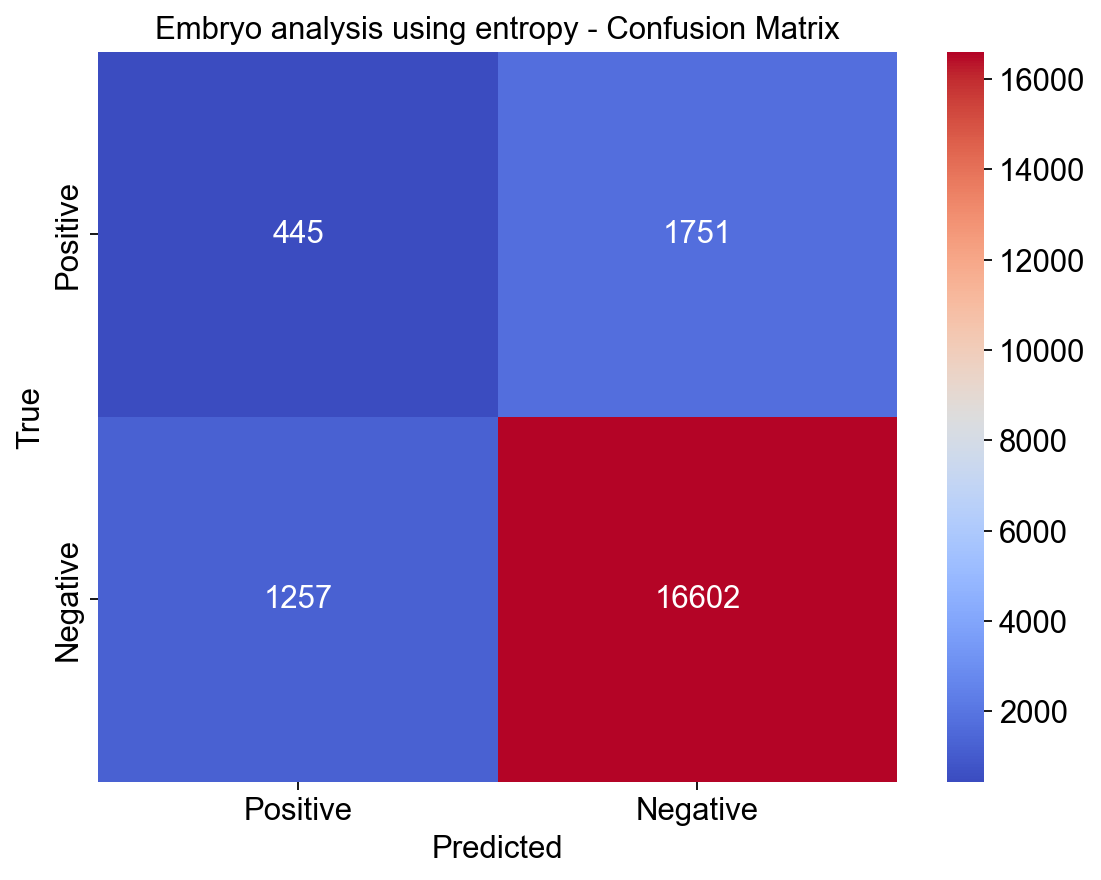

Embryo analysis using entropy - Confusion Matrix
Accuracy: 0.85
Precision: 0.26
Recall: 0.20
F1 score: 0.23


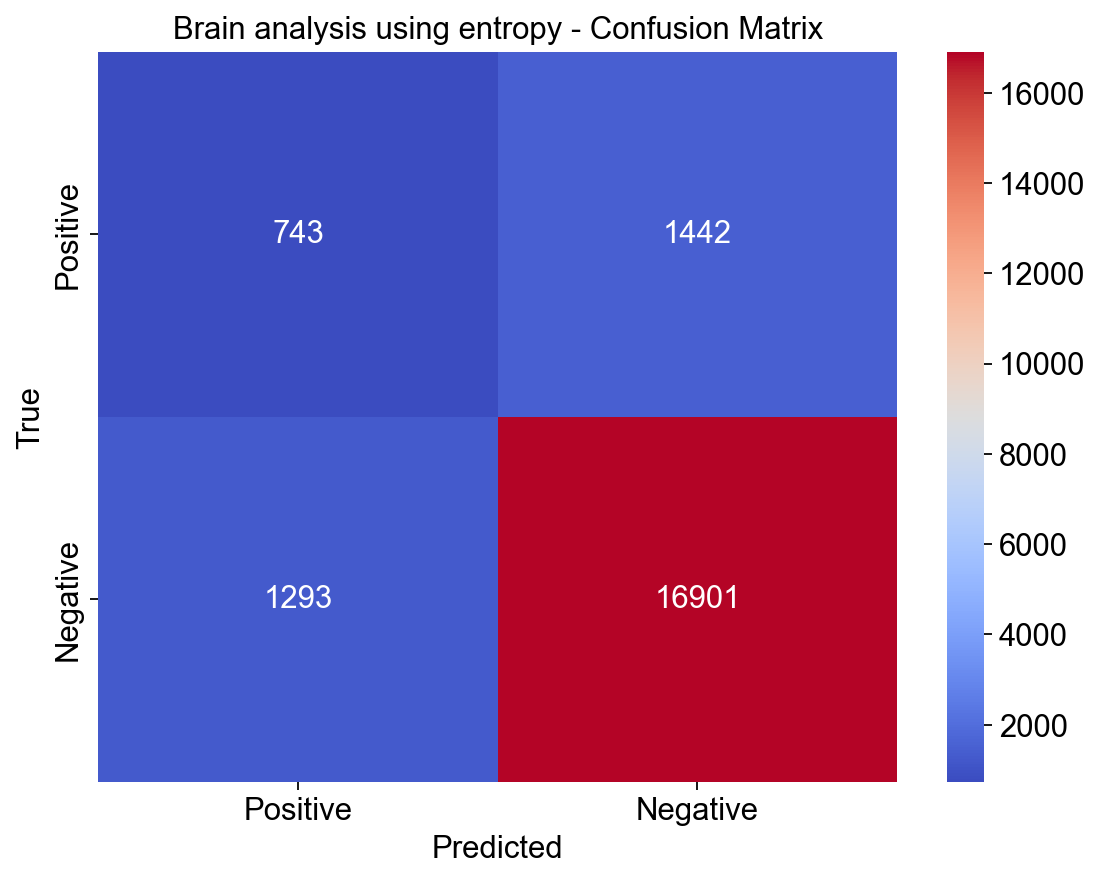

Brain analysis using entropy - Confusion Matrix
Accuracy: 0.87
Precision: 0.36
Recall: 0.34
F1 score: 0.35


In [14]:
utils.perform_confusion_analysis(
    np.load(output_path_embryo + "ground_truth.npy"),
    np.load(output_path_embryo + "entropies_binary.npy"),
    "Embryo analysis using entropy - Confusion Matrix",
)
utils.perform_confusion_analysis(
    np.load(output_path_brain + "ground_truth.npy"),
    np.load(output_path_brain + "entropies_binary.npy"),
    "Brain analysis using entropy - Confusion Matrix",
)

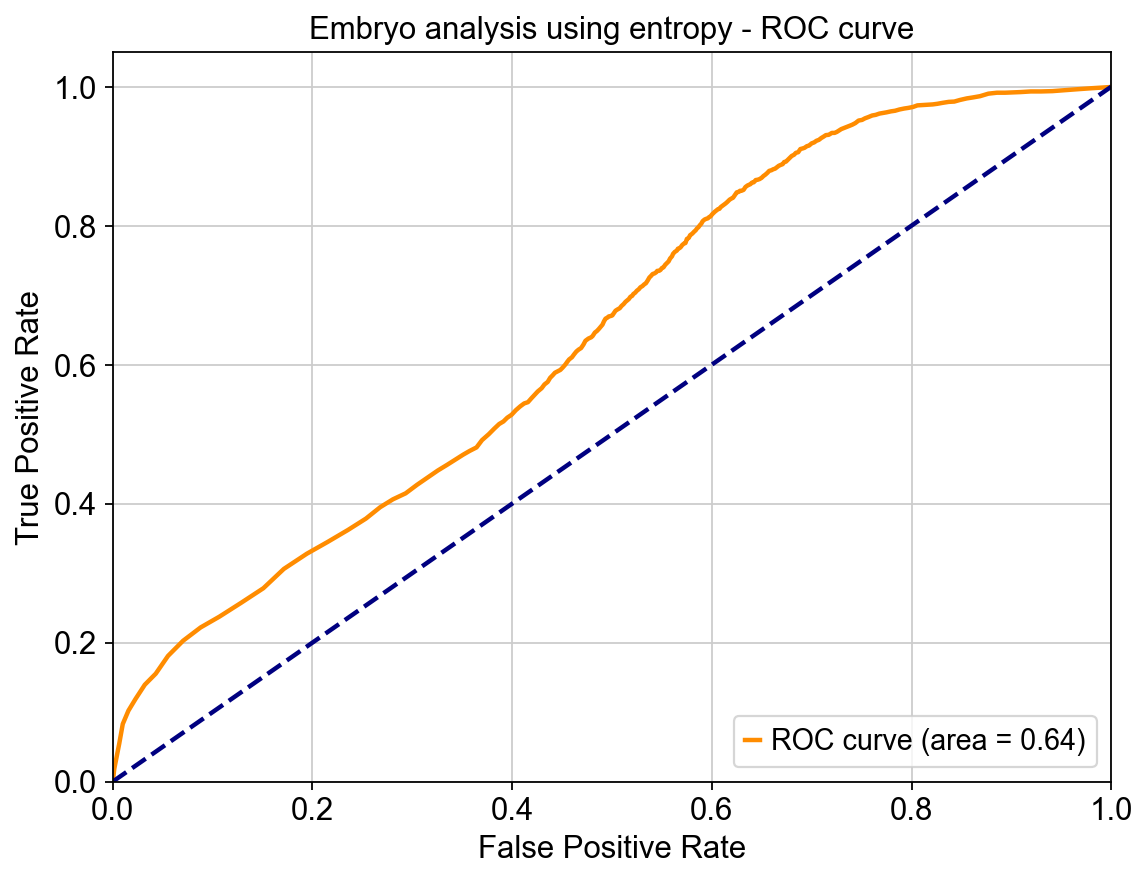

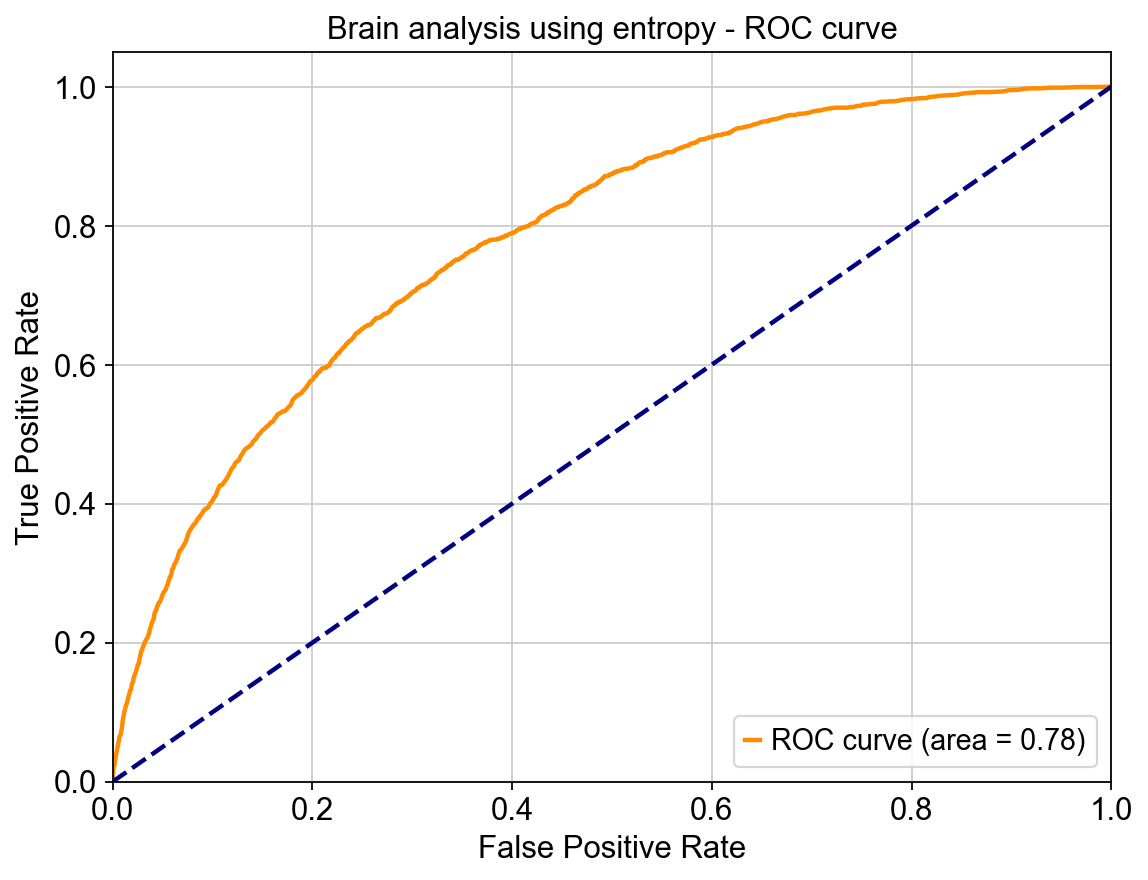

In [15]:
utils.perform_roc_analysis(
    np.load(output_path_embryo + "ground_truth.npy"),
    np.load(output_path_embryo + "entropies_prob.npy"),
    "Embryo analysis using entropy - ROC curve",
)
utils.perform_roc_analysis(
    np.load(output_path_brain + "ground_truth.npy"),
    np.load(output_path_brain + "entropies_prob.npy"),
    "Brain analysis using entropy - ROC curve",
)

#### 6. Analiza modela kNN.

Prikazan je "confusion matrix", kao i ostale relevantne statistike modela klasifikacije. Prikazan je i ROC curve.

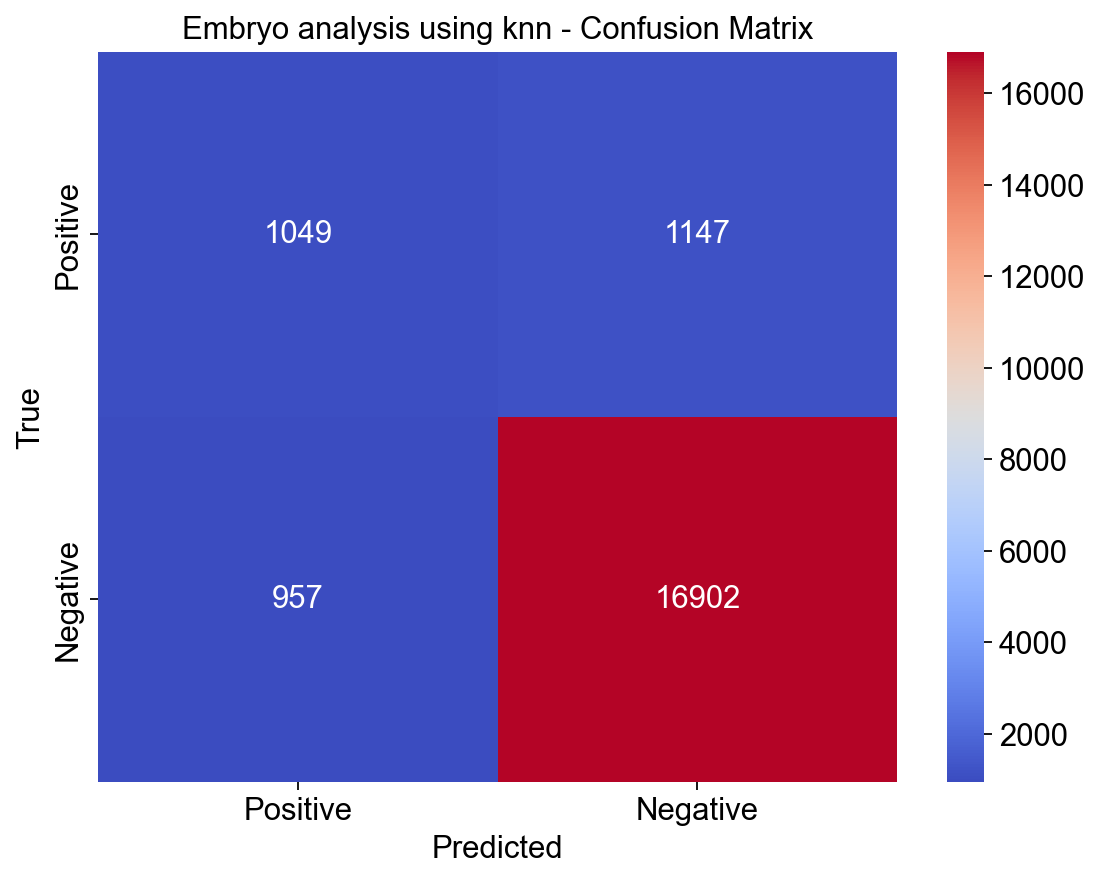

Embryo analysis using knn - Confusion Matrix
Accuracy: 0.90
Precision: 0.52
Recall: 0.48
F1 score: 0.50


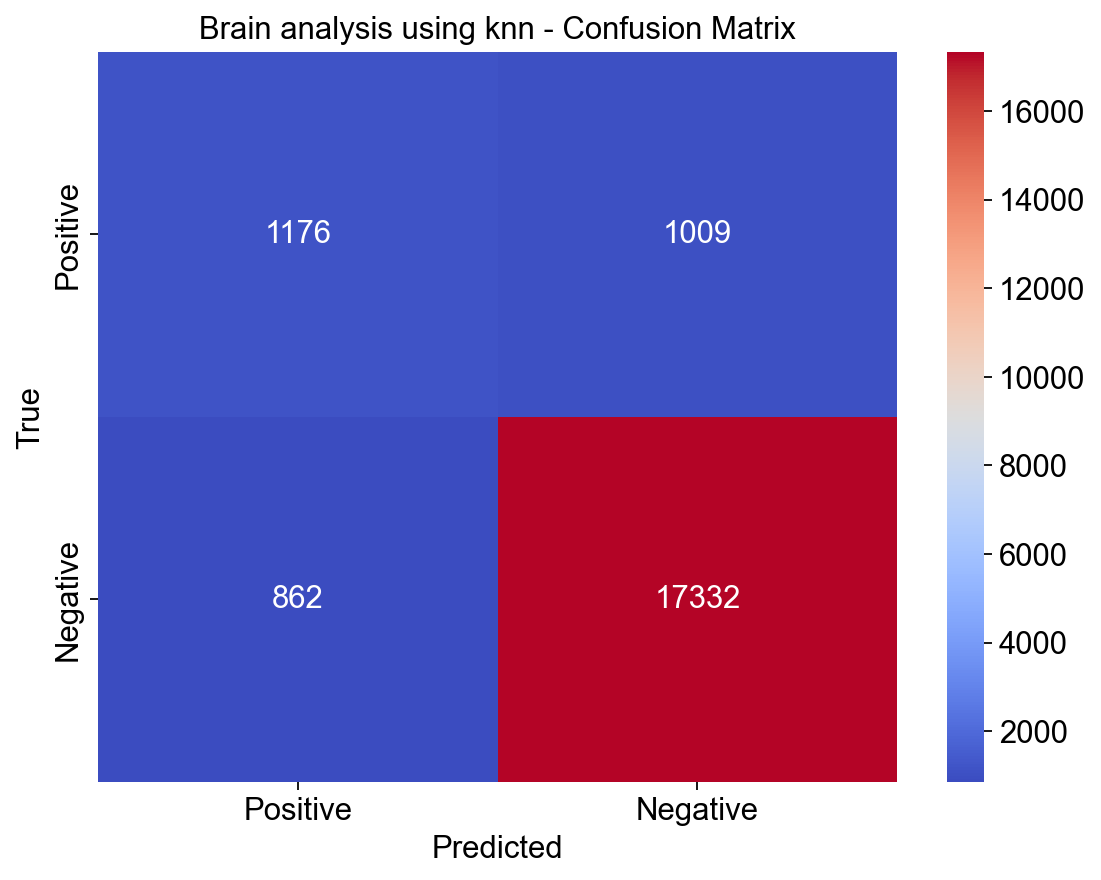

Brain analysis using knn - Confusion Matrix
Accuracy: 0.91
Precision: 0.58
Recall: 0.54
F1 score: 0.56


In [10]:
utils.perform_confusion_analysis(
    np.load(output_path_embryo + "ground_truth.npy"),
    np.load(output_path_embryo + "knn_binary.npy"),
    "Embryo analysis using knn - Confusion Matrix",
)
utils.perform_confusion_analysis(
    np.load(output_path_brain + "ground_truth.npy"),
    np.load(output_path_brain + "knn_binary.npy"),
    "Brain analysis using knn - Confusion Matrix",
)

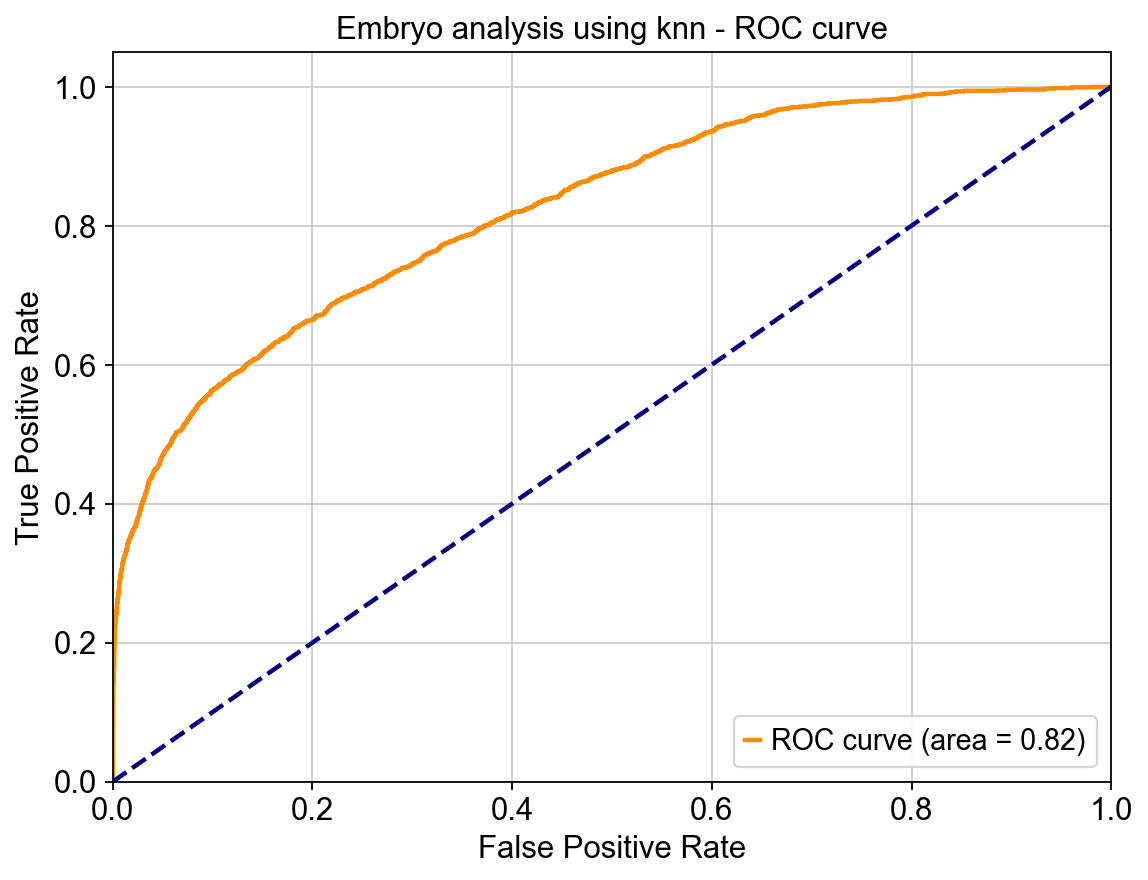

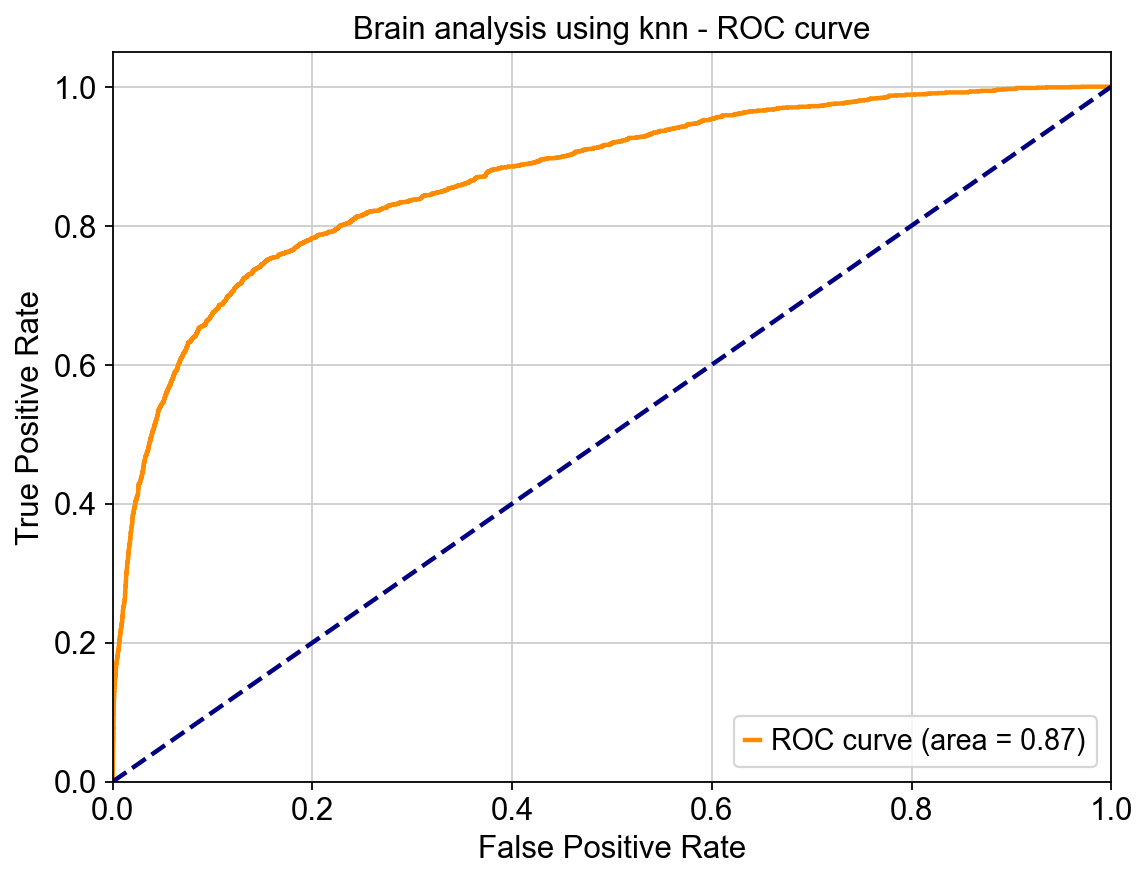

In [11]:
utils.perform_roc_analysis(
    np.load(output_path_embryo + "ground_truth.npy"),
    np.load(output_path_embryo + "knn_prob.npy"),
    "Embryo analysis using knn - ROC curve",
)
utils.perform_roc_analysis(
    np.load(output_path_brain + "ground_truth.npy"),
    np.load(output_path_brain + "knn_prob.npy"),
    "Brain analysis using knn - ROC curve",
)

#### 7. Zaključak

Oba modela u svakom slučaju imaju veliku preciznost što je očekivano zbog toga što se mali procenat gena klasifikuje kao prostorno varijabilan. Ostale statistike su lošije, ali u oba slučaja bolje performanse ima model baziran na kNN algoritmu.